This notebook contains an optimized implementation of the [physics-informed neural network (PINN)](https://github.com/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb) using [JAX](https://docs.jax.dev/en/latest/quickstart.html), [Flax](https://flax.readthedocs.io/en/latest/), and [Optax](https://optax.readthedocs.io/en/latest/).

Here, one-dimensional Burgers equation is solved using PINN approach on the spatial domain $\mathcal{D} = [-1,1]$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

See the [original publication](https://doi.org/10.1002/gamm.202100006) by [Jan Blechschmidt](https://github.com/janblechschmidt) for more details on the methodology.

In [9]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, jacfwd
import flax.linen as nn
from flax.training import train_state
import optax

# Set JAX to use GPU
jax.config.update('jax_platform_name', 'gpu')

# Set data type
DTYPE = jnp.float32

# Set constants
pi = jnp.pi
viscosity = 0.01 / pi

# Define initial condition
def fun_u_0(x):
    return -jnp.sin(pi * x)

# Define boundary condition  
def fun_u_b(t, x):
    n = x.shape[0]
    return jnp.zeros((n, 1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# Lower bounds
lb = jnp.array([tmin, xmin], dtype=DTYPE)
# Upper bounds  
ub = jnp.array([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
key = jax.random.PRNGKey(0)

# Draw uniform sample points for initial boundary data
key, subkey = jax.random.split(key)
t_0 = jnp.ones((N_0, 1), dtype=DTYPE) * lb[0]
x_0 = jax.random.uniform(subkey, (N_0, 1), dtype=DTYPE) * (ub[1] - lb[1]) + lb[1]
X_0 = jnp.concatenate([t_0, x_0], axis=1)

# Evaluate initial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
key, subkey1, subkey2 = jax.random.split(key, 3)
t_b = jax.random.uniform(subkey1, (N_b, 1), dtype=DTYPE) * (ub[0] - lb[0]) + lb[0]
# Random choice between lb[1] and ub[1]
boundary_choice = jax.random.bernoulli(subkey2, 0.5, (N_b, 1))
x_b = boundary_choice * ub[1] + (1 - boundary_choice) * lb[1]
x_b = x_b.reshape((N_b, 1))
X_b = jnp.concatenate([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b, x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
key, subkey1, subkey2 = jax.random.split(key, 3)
t_r = jax.random.uniform(subkey1, (N_r, 1), dtype=DTYPE) * (ub[0] - lb[0]) + lb[0]
x_r = jax.random.uniform(subkey2, (N_r, 1), dtype=DTYPE) * (ub[1] - lb[1]) + lb[1]
X_r = jnp.concatenate([t_r, x_r], axis=1)

# Collect boundary and initial data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

# Define neural network model
class PINN(nn.Module):
    num_hidden_layers: int = 8
    num_neurons_per_layer: int = 20
    
    @nn.compact
    def __call__(self, x):
        # Input scaling layer to map input to [lb, ub]
        x_scaled = 2.0 * (x - lb) / (ub - lb) - 1.0
        
        # Hidden layers
        for _ in range(self.num_hidden_layers):
            x_scaled = nn.Dense(self.num_neurons_per_layer)(x_scaled)
            x_scaled = nn.tanh(x_scaled)
        
        # Output layer
        x_scaled = nn.Dense(1)(x_scaled)
        return x_scaled

def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    model = PINN(num_hidden_layers=num_hidden_layers, 
                 num_neurons_per_layer=num_neurons_per_layer)
    key = jax.random.PRNGKey(0)
    dummy_input = jnp.ones((1, 2), dtype=DTYPE)
    params = model.init(key, dummy_input)
    return model, params

# Initialize model
model, initial_params = init_model()

# Create closure for residual function to capture model statically
def make_get_r(model):
    def get_r(params, X_r):
        def u_fn(tx):
            return model.apply(params, tx[None, :])[0, 0]
        
        # Vectorize the u_fn over inputs
        u_vec = vmap(u_fn)
        
        # Define function to compute derivatives at a single point
        def derivatives(tx):
            grad_u = grad(u_fn)(tx)
            hess_func = jax.jit(jax.jacfwd(jax.jacrev(u_fn))) #jacfwd(grad)(u_fn)(tx)
            hess_u = hess_func(tx)
            u = u_fn(tx)
            u_t = grad_u[0]
            u_x = grad_u[1]
            u_xx = hess_u[1, 1]  # d²u/dx²
            return u, u_t, u_x, u_xx
        
        # Vectorize derivatives computation
        u, u_t, u_x, u_xx = vmap(derivatives)(X_r)
        
        # Reshape to column vectors
        t = X_r[:, 0:1]
        x = X_r[:, 1:2]
        u = u.reshape(-1, 1)
        u_t = u_t.reshape(-1, 1)
        u_x = u_x.reshape(-1, 1)
        u_xx = u_xx.reshape(-1, 1)
        
        return fun_r(t, x, u, u_t, u_x, u_xx)
    return get_r

# Create closure for loss function to capture model statically
def make_compute_loss(model):
    get_r = make_get_r(model)
    
    @jit
    def compute_loss(params, X_r, X_data, u_data):
        # Compute phi^r
        r = get_r(params, X_r)
        phi_r = jnp.mean(jnp.square(r))
        
        # Initialize loss
        loss = phi_r
        
        # Add phi^0 and phi^b to the loss
        for i in range(len(X_data)):
            u_pred = model.apply(params, X_data[i])
            loss += jnp.mean(jnp.square(u_data[i] - u_pred))
        
        return loss
    return compute_loss

# Create loss function with model captured
compute_loss_fn = make_compute_loss(model)

# Create learning rate schedule
def create_schedule():
    return optax.piecewise_constant_schedule(
        init_value=1e-2,
        boundaries_and_scales={1000: 0.1, 3000: 0.5}
    )

# Create optimizer
learning_rate = create_schedule()
optimizer = optax.adam(learning_rate)

# Create training state
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=initial_params,
    tx=optimizer
)

# Training step function
@jit
def train_step(state, X_r, X_data, u_data):
    def loss_fn(params):
        return compute_loss_fn(params, X_r, X_data, u_data)
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Training loop
def train_model(state, num_epochs=5000):
    losses = []
    
    for epoch in range(num_epochs):
        state, loss = train_step(state, X_r, X_data, u_data)
        losses.append(float(loss))
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.6f}")
    
    return state, losses

# Train the model
trained_state, loss_history = train_model(state)

# Function to make predictions
@jit
def predict(params, X):
    return model.apply(params, X)

print("JAX PINN model trained successfully!")
print(f"Final loss: {loss_history[-1]:.6f}")

Epoch 0, Loss: 1.306263
Epoch 500, Loss: 0.032522
Epoch 1000, Loss: 0.001659
Epoch 1500, Loss: 0.001070
Epoch 2000, Loss: 0.000813
Epoch 2500, Loss: 0.000612
Epoch 3000, Loss: 0.000447
Epoch 3500, Loss: 0.000375
Epoch 4000, Loss: 0.000314
Epoch 4500, Loss: 0.000253
JAX PINN model trained successfully!
Final loss: 0.000208


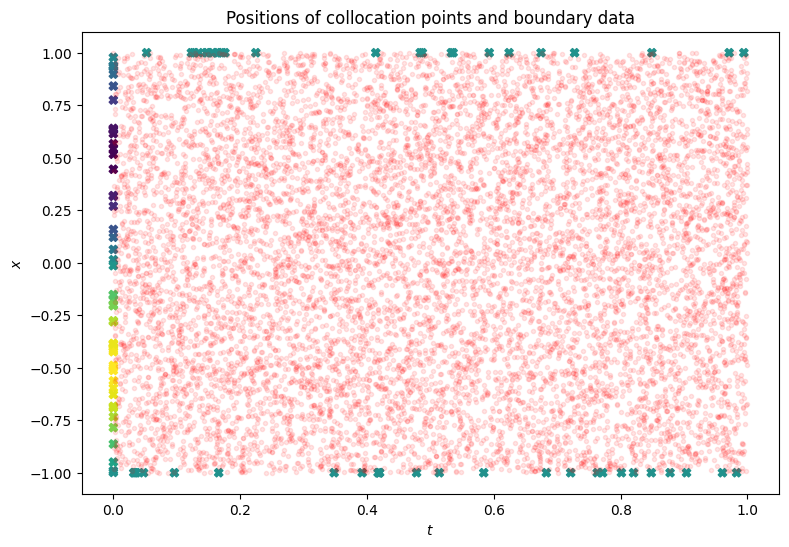

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

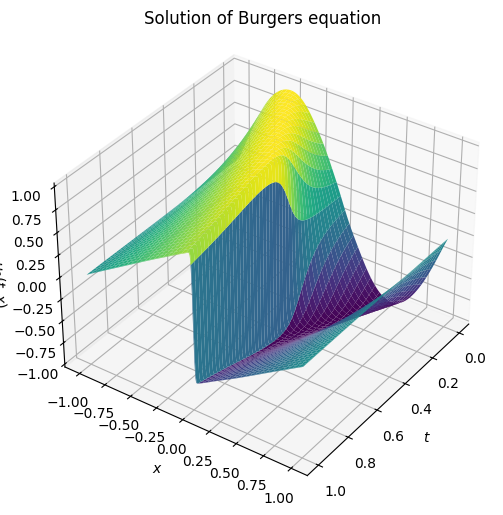

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = jnp.linspace(lb[0], ub[0], N + 1)
xspace = jnp.linspace(lb[1], ub[1], N + 1)
T, X = jnp.meshgrid(tspace, xspace, indexing='ij')  # Use 'ij' indexing for matrix orientation
Xgrid = jnp.stack([T.flatten(), X.flatten()], axis=1).astype(DTYPE)

# Determine predictions of u(t, x)
upred = predict(trained_state.params, Xgrid)

# Reshape upred - note: upred has shape (num_points, 1)
U = upred.reshape(N + 1, N + 1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');

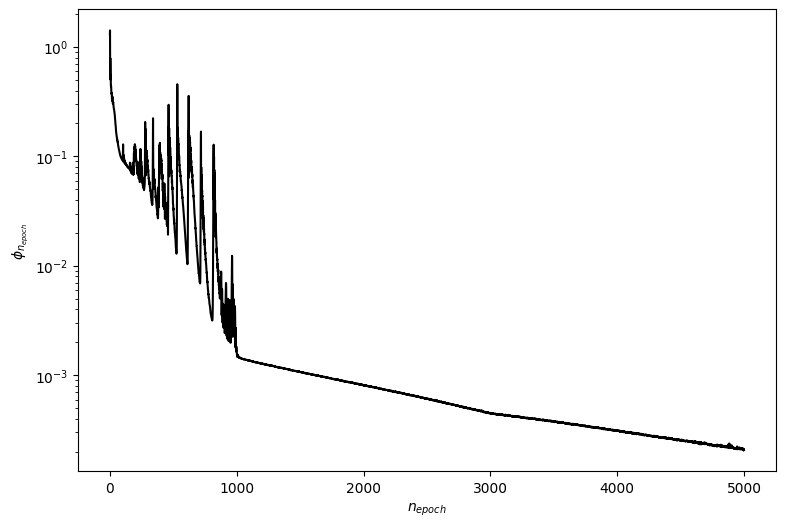

In [6]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(loss_history)), loss_history,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');